In [11]:
# helper
from graphviz import Digraph

def _trace(root):
    """Collect all nodes and edges reachable from `root`."""
    nodes, edges = set(), []

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.append((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    """
    Render the autograd graph starting at `root`
    (returns a Digraph you can display or save).
    """
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = _trace(root)

    for n in nodes:                                     # node style
        uid = str(id(n))
        label = f"{n.data}"
        if n.operation:
            label += f" | {n.operation}"
        label += f" | ∇={n.grad}"
        dot.node(uid, label=label, shape="record")

    for src, dst in edges:                              # edge style
        dot.edge(str(id(src)), str(id(dst)))

    return dot


In [12]:
class Value():
    def __init__(self, data, operation="", children=[]):
        self.data = data
        self.operation = operation
        self.children = children
        self.grad = 0.0

    def __repr__(self):
        return str(self.data)

    def __add__(self, other):
        return Value(self.data + other.data, "+", [self, other])

    def __mul__(self, other):
        return Value(self.data * other.data, "*", [self, other])

In [22]:
a = Value(10)
b = Value(20)
c = Value(2)
d = a + b
e = d * c
loss = e * Value(0.2)

$$ \frac{\mathrm{dL}}{\mathrm{dL}} = 1.0 $$
$$ \mathrm{L} = 0.2 \mathrm{e} \implies \frac{\mathrm{dL}}{\mathrm{de}} = 0.2 $$
$$ \mathrm{e} = \mathrm{d} \times \mathrm{c} \implies \frac{\mathrm{de}}{\mathrm{dd}} = \mathrm{c} \quad \frac{\mathrm{de}}{\mathrm{dc}} = \mathrm{d} $$
$$ \mathrm{d} = \mathrm{a} + \mathrm{b} \implies \frac{\mathrm{dd}}{\mathrm{da}} = 1 \quad \frac{\mathrm{dd}}{\mathrm{db}} = 1$$

In [25]:
loss.grad = 1
e.grad = 0.2 * loss.grad
d.grad = c.data * e.grad
c.grad = d.data * e.grad
a.grad = 1 * d.grad
b.grad = 1 * d.grad

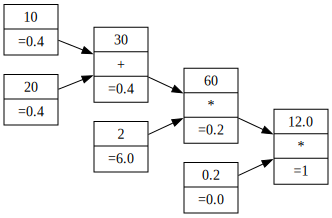

In [26]:
dot = draw_dot(loss)
dot